In [1]:
import torch
import torch.nn as nn

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt

## Exploring MNIST dataset

### Downloading/Loading torchvision.dataset.MNIST. 

In [17]:
# Training dataset

dataset = MNIST(root='data/')
len(dataset)

60000

Data is of type PIL image.

In [18]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

In [19]:
# Testing dataset

test_dataset = MNIST(root='data/', train = False)
len(test_dataset)

10000

Plotting first 10 images in the dataset along with their target labels.

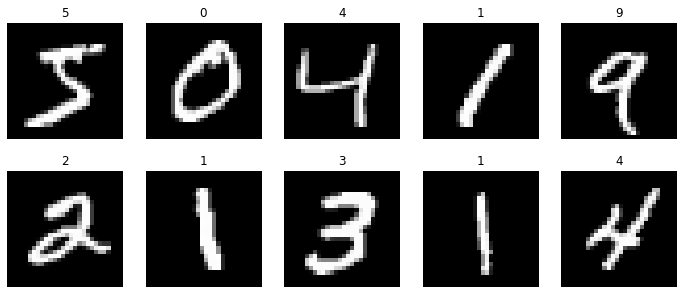

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

for i in range(10):
    axes[i//5, i%5].imshow(dataset[i][0], cmap='gray')
    axes[i//5, i%5].set_title(dataset[i][1])
    axes[i//5, i%5].axis("off")

### Loading MNIST as tensors

torch.Size([1, 28, 28])


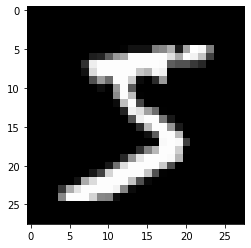

In [28]:
dataset = MNIST(root='data/', transform=transforms.ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

img_tensor, label = dataset[0]
print(img_tensor.shape)

plt.imshow(img_tensor[0,:,:], cmap='gray')
plt.show()

In [29]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

### Splitting dataset to training and validation

In [30]:
train_set, val_set = random_split(dataset, [50000, 10000])

print(len(train_set), len(val_set))

50000 10000


### Creating dataloader

In [31]:
batch_size = 10000

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)

### Creating model

In [32]:
input_size = 28*28
num_classes = 10

In [33]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
            
    ## Returns the value after forward pass
    def forward(self, x):
        
        # Reshaping from 28x28 to 784, and first value (-1)
        x = x.reshape(-1, 784)
        
        x1 = self.linear(x)
        return x1
    
    ## Returns loss for a training batch
    def training_step(self, batch):
        images, labels = batch 
        
        # Generate predictions
        out = self(images)            
        
        # Calculate loss
        loss = loss_function(out, labels) 
        return loss
    
    ## Returns the loss and accuracy for a validation batch
    def validation_step(self, val_batch):
        images, labels = val_batch 
        
        # Generate predictions
        out = self(images)            
        
        # Calculate loss
        val_loss = loss_function(out, labels) 
        val_acc = accuracy(out, labels)
        
        return {"val_loss":val_loss, "val_acc":val_acc}
    
    ## Returns mean loss and mean accuracy from the losses and accuracies of all the batches
    def validation_epoch_end(self, outputs):
        
        # Losses for each batch
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Mean loss for all batch
        batch_mean_loss = torch.tensor(batch_losses).mean()
        
        # Accuracies for each batches
        batch_accs = [x['val_acc'] for x in outputs]
        
        # Mean accuracy for all batches
        batch_mean_acc = torch.tensor(batch_accs).mean()
        
        return {"val_loss":batch_mean_loss, "val_acc":batch_mean_acc}
    
    ## Prints validation loss and accuracy for epoch (mean of all batches)
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [34]:
model = Model()

Checking sample outputs from instantiated model using one batch of dataset.

In [44]:
for images, labels in train_loader:
    print("Image shape: ", images.shape)
    outputs = model(images)
    break

print("Output shape: ", outputs.shape)

Image shape:  torch.Size([10000, 1, 28, 28])
Output shape:  torch.Size([10000, 10])


### Softmax function

Getting probability values for every class.

In [45]:
output_prob = nn.functional.softmax(outputs, dim = 1)

# Checking probabilities
print("Sample probabilities:\n", output_prob[0].data)

# Adding the probabilities, we get 1
print("Sum: ", torch.sum(output_prob[0]).item())

Sample probabilities:
 tensor([0.1170, 0.0940, 0.1156, 0.0787, 0.1213, 0.0856, 0.1106, 0.1056, 0.0749,
        0.0967])
Sum:  1.0


In [46]:
# Finding label predictions with maximum probabilites
max_probs, preds = torch.max(output_prob, dim=1)

print(preds[:10],'\n')
print(max_probs.data[:10])

tensor([4, 2, 0, 3, 2, 8, 5, 5, 8, 2]) 

tensor([0.1213, 0.1314, 0.1186, 0.1275, 0.1301, 0.1372, 0.1311, 0.1253, 0.1648,
        0.1255])


In [47]:
# Comparing with actual labels
labels[:10]

tensor([6, 6, 2, 1, 8, 0, 4, 9, 2, 7])

### Evaluation metric

Total number of correct prediction labels:

In [48]:
torch.sum(preds==labels)

tensor(712)

Defining accuracy as total correct no. of predictions predictions divided by total no. of predictions.

In [49]:
# Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [50]:
accuracy(output_prob, labels)

tensor(0.0712)

### Loss function

In [53]:
loss_function = nn.functional.cross_entropy

# Since gradients not needed, we can use torch.no_grad()
with torch.no_grad():
    print(loss_function(output_prob, labels))

tensor(2.3057)


### Optimizer

In [54]:
learning_rate = 0.05
sgd = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training

In [56]:
# Utility function to train the model

def fit(epochs, model, optimizer, train_loader, val_loader):
    print("Training")
    
    # For recording epoch wise results
    history = []
    
    for i in range(epochs):
        for batch in train_loader:
            
            # Make prediction & Calculate loss
            loss = model.training_step(batch)
            
            # Compute gradients
            loss.backward()
            
            # Update parameters using gradients
            optimizer.step()
            
            # Reset gradients to zero
            optimizer.zero_grad()
            
        ## Validation phase 
        result = evaluate(model, val_loader)
        model.epoch_end(i, result)
        history.append(result)
            
    return history

In [57]:
def evaluate(model, val_loader):
    
    # List containing evaluations for every batch
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

In [58]:
history = fit(30, model, sgd, train_loader, val_loader)

Training
Epoch [0], val_loss: 2.0941, val_acc: 0.4826
Epoch [1], val_loss: 1.8891, val_acc: 0.6549
Epoch [2], val_loss: 1.7192, val_acc: 0.7075
Epoch [3], val_loss: 1.5785, val_acc: 0.7354
Epoch [4], val_loss: 1.4616, val_acc: 0.7542
Epoch [5], val_loss: 1.3640, val_acc: 0.7666
Epoch [6], val_loss: 1.2819, val_acc: 0.7784
Epoch [7], val_loss: 1.2121, val_acc: 0.7891
Epoch [8], val_loss: 1.1524, val_acc: 0.7961
Epoch [9], val_loss: 1.1007, val_acc: 0.8020
Epoch [10], val_loss: 1.0556, val_acc: 0.8066
Epoch [11], val_loss: 1.0160, val_acc: 0.8112
Epoch [12], val_loss: 0.9810, val_acc: 0.8148
Epoch [13], val_loss: 0.9497, val_acc: 0.8183
Epoch [14], val_loss: 0.9217, val_acc: 0.8202
Epoch [15], val_loss: 0.8964, val_acc: 0.8229
Epoch [16], val_loss: 0.8735, val_acc: 0.8263
Epoch [17], val_loss: 0.8526, val_acc: 0.8286
Epoch [18], val_loss: 0.8334, val_acc: 0.8312
Epoch [19], val_loss: 0.8159, val_acc: 0.8330
Epoch [20], val_loss: 0.7997, val_acc: 0.8342
Epoch [21], val_loss: 0.7847, val_a

Now we plot the evaluation metrics for all epochs.

In [59]:
losses = [l['val_loss'] for l in history]
acc = [a['val_acc'] for a in history]

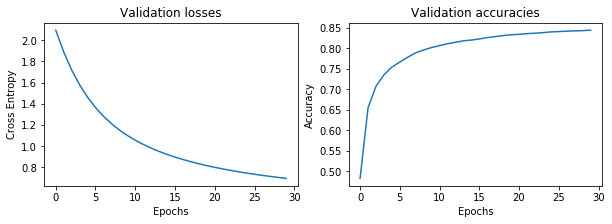

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

axes[0].plot(losses)
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Cross Entropy")
axes[0].set_title("Validation losses")

axes[1].plot(acc)
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation accuracies")
plt.show()

### Checking model performance on test dataset

In [82]:
test_loader = DataLoader(test_dataset, int(batch_size/2))


In [88]:
result = evaluate(model, test_loader)
print("Test Loss = {:.4f}, Test accuracy = {:.4F}".format(result['val_loss'], result['val_acc']))

Test Loss = 0.6559, Test accuracy = 0.8597
